In [1]:
import gymnasium
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from utils import visualise_pricing_strategy, visualise_episode_rewards, external_demand_function,visualise_demand_data
from Pricing_Environment import demand_calculator, action_strategy,pricing_env


In [2]:
import random
random.seed(42)
np.random.seed(42)


In [3]:
product_config = {
    "min_price": 10,
    "max_price": 100,
    "initial_demand": 0.5,
}

demand_calculator_config = {
    "price_probability_ranges": {
        (0, 50): 0.8,   # 80% demand probability for prices between $0 and $50
        (51, 100): 0.6, # 60% demand probability for prices between $51 and $100
        # Add more ranges a
        # nd probabilities as needed
    },
    'low':0,
    'high':100,
    'seasonality':True
}

action_strategy_config = {
    "action_probabilities": {
        0: 0.1,  # Decrease price significantly
        1: 0.2,  # Decrease price slightly
        2: 0.4,  # Keep price
        3: 0.2,  # Increase price slightly
        4: 0.1,  # Increase price significantly
    },
    "price_change_map": {
        0: -10,  # Decrease significantly
        1: -5,   # Decrease slightly
        2: 0,    # Keep price
        3: 5,    # Increase slightly
        4: 10    # Increase significantly
    }
}


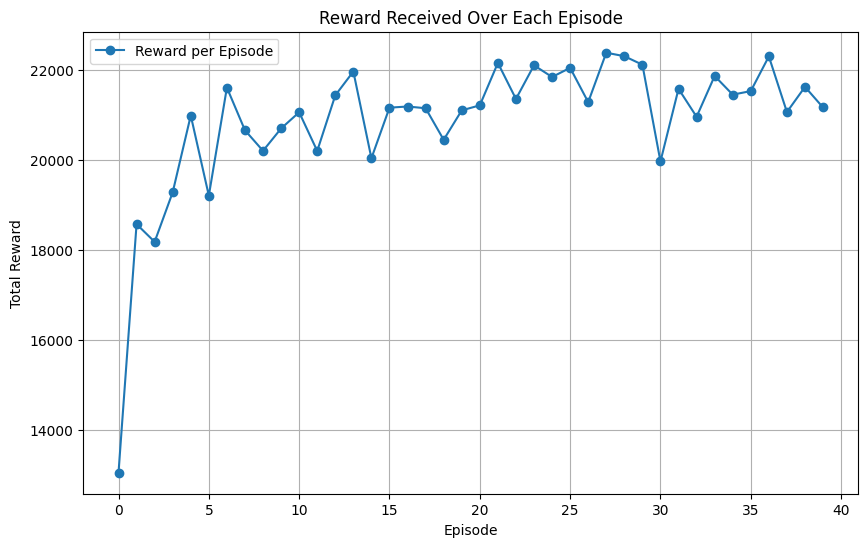

In [4]:

# Initialize the environment and strategy
env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=False, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)

strategy = action_strategy.ActionStrategy(action_strategy_config['action_probabilities'],epsilon=0.1)
num_episodes = 40
max_steps_per_episode = 250
episode_rewards = []

for episode in range(num_episodes):
    initial_state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = strategy.choose_action()
        external_demand = np.random.uniform(0.5, 1.5)  # Simulate external market demand
        state, reward, done, _ = env.step(action, external_demand)
        strategy.update_probabilities(action, reward)  # Update the strategy based on the reward
        
        total_reward += reward
        if done:
            break

    #print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    episode_rewards.append(total_reward)

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)



In [5]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_rate=0.95,
                 exploration_rate=1.0, exploration_decay=0.99, min_exploration_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

    def act(self, state):
        # Exploration-exploitation trade-off
        if np.random.rand() < self.exploration_rate:
            return np.random.choice(range(self.action_size))
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        # Update Q-value using the Bellman equation
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_rate * self.q_table[next_state][best_next_action] * (not done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        # Decay exploration rate
        if done:
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)


In [6]:
### Ürüne olan demande göre state definition yapılmalı

def encode_state(market_demand, num_bins=10, max_market_demand=1.5):
    """
    Encodes the market demand into a discrete state based on the ratio of 
    market_demand to the maximum market demand.

    Args:
        market_demand (float): The current market demand from the environment's state.
        num_bins (int): The number of bins to discretize the demand ratio into.
        max_market_demand (float): The maximum possible market demand to normalize the ratio.

    Returns:
        int: A discrete integer representing the encoded state.
    """
    # Normalize market demand
    normalized_demand = market_demand / max_market_demand
    
    # Discretize the normalized demand
    discrete_state = int(normalized_demand * num_bins)
    # Ensure the discrete state is within the bounds [0, num_bins-1]
    discrete_state = min(max(discrete_state, 0), num_bins - 1)
    
    return discrete_state


Episode 1: Total Reward = 9488.617238952937
Episode 2: Total Reward = 7442.413286534994
Episode 3: Total Reward = 7629.905687635324
Episode 4: Total Reward = 8910.911437839359
Episode 5: Total Reward = 6835.838670746502
Episode 6: Total Reward = 12651.25737601885
Episode 7: Total Reward = 8603.805026981281
Episode 8: Total Reward = 11393.971190786668
Episode 9: Total Reward = 11294.178241428514
Episode 10: Total Reward = 15982.546031295708
Episode 11: Total Reward = 12073.226747196228
Episode 12: Total Reward = 10389.890522334099
Episode 13: Total Reward = 13349.733968183271
Episode 14: Total Reward = 17851.443882506326
Episode 15: Total Reward = 10418.651211695797
Episode 16: Total Reward = 13226.977326663675
Episode 17: Total Reward = 11571.823337160358
Episode 18: Total Reward = 14461.656359120441
Episode 19: Total Reward = 15539.5648554893
Episode 20: Total Reward = 13842.821242216898
Episode 21: Total Reward = 16802.658612047995
Episode 22: Total Reward = 8604.857956909631
Episode

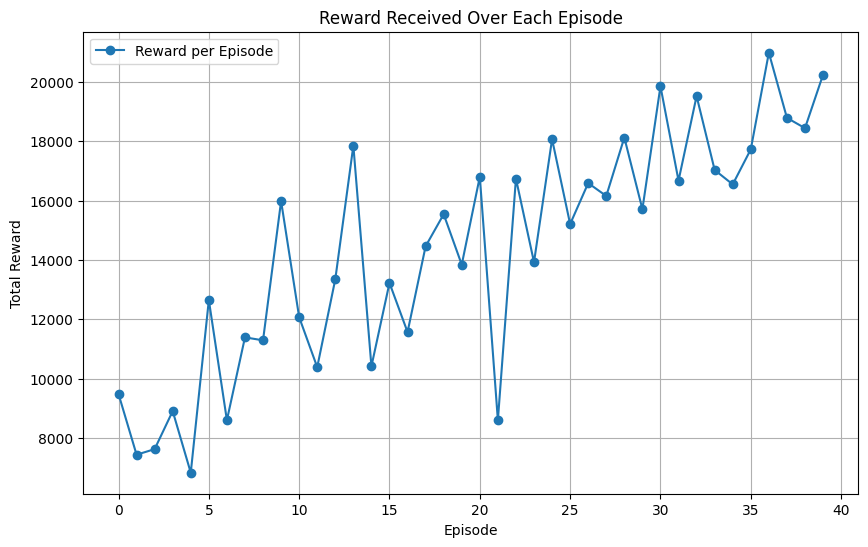

In [7]:

# Initialize the environment with the configs
env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=False, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)

# Initialize the Q-learning agent
# Assuming state_size is determined by your environment's specifics
agent = QLearningAgent(state_size=15, action_size=5)
num_bins = 15  # Define the granularity of your discretization
state_bounds = [(env.min_price, env.max_price)]

num_episodes = 40
max_steps_per_episode = 250

episode_rewards = []
for episode in range(num_episodes):
    initial_state = env.reset()
    market_demand = initial_state[0]  # Extract market demand from the state
    state = encode_state(market_demand, num_bins=num_bins)  # Encode the initial state
    
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state_info, reward, done, _ = env.step(action, external_demand_function())  # Simulate action and external demand
        next_market_demand = next_state_info[0]  # Extract market demand from the next state TODO 
        next_state = encode_state(next_market_demand, num_bins=num_bins)  # Encode the next state

        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        

        if done:
            break
 
    agent.exploration_rate = max(agent.min_exploration_rate, agent.exploration_rate * agent.exploration_decay)
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        

    episode_rewards.append(total_reward)   

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)


In [8]:
def encode_state(market_demand, boundaries):
    """
    Encodes the market demand into a discrete state based on specified boundaries.

    Args:
        market_demand (float): The current market demand from the environment's state.
        boundaries (list of floats): The boundaries between different demand bins. Should be sorted in ascending order.

    Returns:
        int: A discrete integer representing the encoded state. Returns the index of the bin into which the market demand falls.
    """
    # Iterate over the boundaries to determine the correct bin
    for i, boundary in enumerate(boundaries):
        if market_demand < boundary:
            return i
    # If the demand is greater than all boundaries, return the last bin index
    return len(boundaries)

# Example usage
boundaries = [0.3, 0.6, 0.9, 1.2]  # Define boundaries for market demand bins
market_demand = 0.75  # Current market demand

# Encode the current market demand
state = encode_state(market_demand, boundaries)
print("Encoded state:", state)


Encoded state: 2


Episode 1: Total Reward = 12483.754353202903
Episode 2: Total Reward = 8749.59994357059
Episode 3: Total Reward = 10180.852561198002
Episode 4: Total Reward = 6523.702713682308
Episode 5: Total Reward = 6606.994255142125
Episode 6: Total Reward = 10822.096422099336
Episode 7: Total Reward = 8447.890632763543
Episode 8: Total Reward = 12499.043429062634
Episode 9: Total Reward = 9379.182583594975
Episode 10: Total Reward = 13978.260668188805
Episode 11: Total Reward = 13729.18365676146
Episode 12: Total Reward = 11339.92501253276
Episode 13: Total Reward = 13284.668387413401
Episode 14: Total Reward = 10933.92106373944
Episode 15: Total Reward = 14310.615807978113
Episode 16: Total Reward = 14048.276302080834
Episode 17: Total Reward = 16423.19349115076
Episode 18: Total Reward = 14801.354978658776
Episode 19: Total Reward = 17295.43841495034
Episode 20: Total Reward = 15801.893536661713
Episode 21: Total Reward = 17149.78662764525
Episode 22: Total Reward = 14871.792763739251
Episode 2

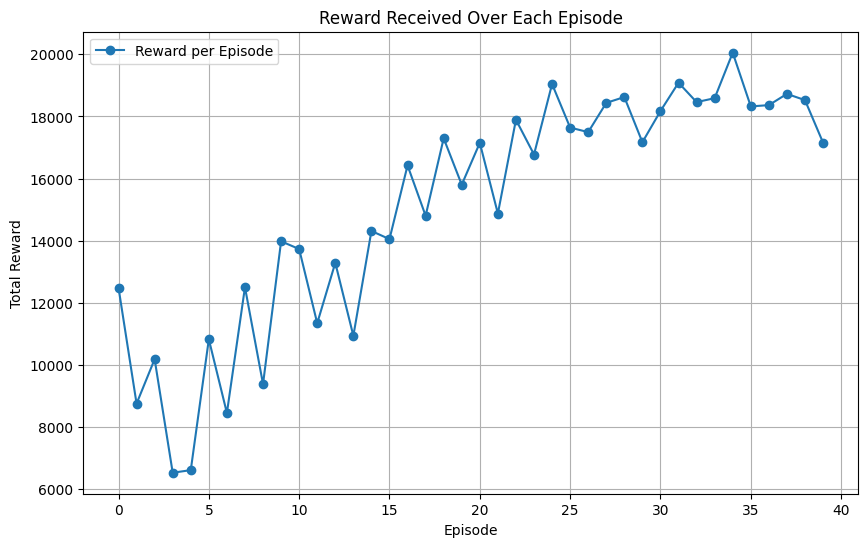

In [9]:
# Define boundaries based on expected ranges of market demand
# For example, if market demands typically range from 0 to 1.5, you might define:
boundaries = [0.3, 0.6, 0.9, 1.2, 1.5]

# Assuming state_size should now correspond to the number of bins derived from the boundaries
state_size = len(boundaries) + 1  # plus one for demands above the highest boundary

# Initialize the Q-learning agent with the updated state size
agent = QLearningAgent(state_size=state_size, action_size=5)

# Simulation loop adjusted for new encode_state usage
num_episodes = 40
max_steps_per_episode = 250
episode_rewards = []

for episode in range(num_episodes):
    initial_state = env.reset()
    market_demand = initial_state[0]  # Extract market demand from the state
    state = encode_state(market_demand, boundaries)  # Encode the initial state using new boundaries
    
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state_info, reward, done, _ = env.step(action, external_demand_function())  # Simulate action and external demand
        next_market_demand = next_state_info[0]  # Extract market demand from the next state
        next_state = encode_state(next_market_demand, boundaries)  # Encode the next state using new boundaries

        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        
        if done:
            break

    agent.exploration_rate = max(agent.min_exploration_rate, agent.exploration_rate * agent.exploration_decay)
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    episode_rewards.append(total_reward)

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)


[144.         115.22888291 147.4391372  182.61241666 148.73093557
 168.77773831 149.73695644 115.59404917 199.33602385 175.95163291
 120.43154434 194.76848318 109.95734176 152.9952572  148.88165472
 112.61825643 150.20905518 140.66025404 190.98017227 205.17911923
 107.26923806 114.26432163 175.17960345 116.03152674 161.83749518
 126.61560906 175.38439094 174.16250482 149.96847326 123.82039655
 101.73567837 180.73076194 160.82088077 183.01982773 156.33974596
 174.79094482 180.38174357 161.11834528 165.0047428  163.04265824
 139.23151682 160.56845566 131.04836709 100.66397615 184.40595083
 117.26304356 119.22226169 120.26906443 165.38758334 182.5608628
 109.77111709 157.        ]


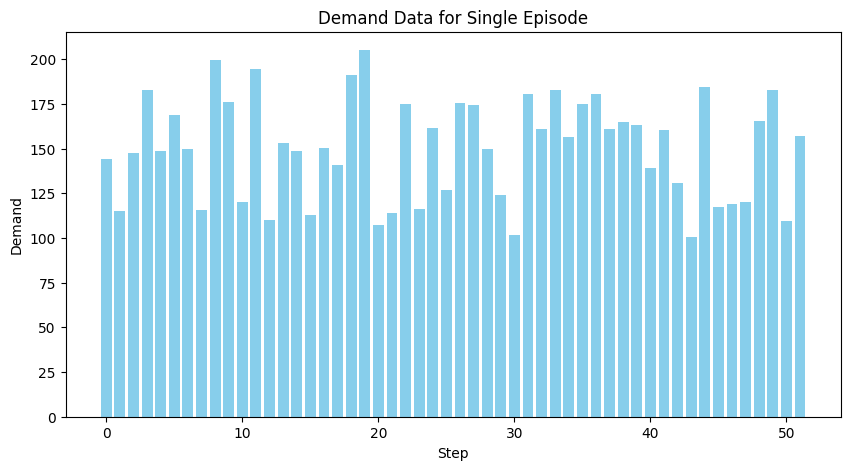

In [11]:

# Example usage:
generator = demand_calculator.DemandDataGenerator(low=100, high=200, steps=52, seasonality=True)
demand_data = generator.generate()
print(demand_data)
visualise_demand_data(demand_data)


In [33]:
action_prices = {
    0: 70,  # Price option 1
    1: 80,  # Price option 2
    2: 90, # Price option 3
    3: 95, # Price option 4
    4: 100  # Price option 5
}

# Example of a more granular action_prices for "continuous" prices
#action_prices = {i: price for i, price in enumerate(range(70, 101, 5))}  # Prices from 70 to 100 in steps of 5


class UCB1:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.action_counts = np.zeros(n_actions, dtype=int)
        self.total_rewards = np.zeros(n_actions, dtype=float)
        
    def select_action(self):
        for action in range(self.n_actions):
            if self.action_counts[action] == 0:
                return action
        ucb_values = self.total_rewards / self.action_counts + np.sqrt(2 * np.log(sum(self.action_counts)) / self.action_counts)
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        self.action_counts[action] += 1
        self.total_rewards[action] += reward


# Adjusted to map actions directly to specific prices


In [34]:
action_prices

{0: 70, 1: 80, 2: 90, 3: 95, 4: 100}

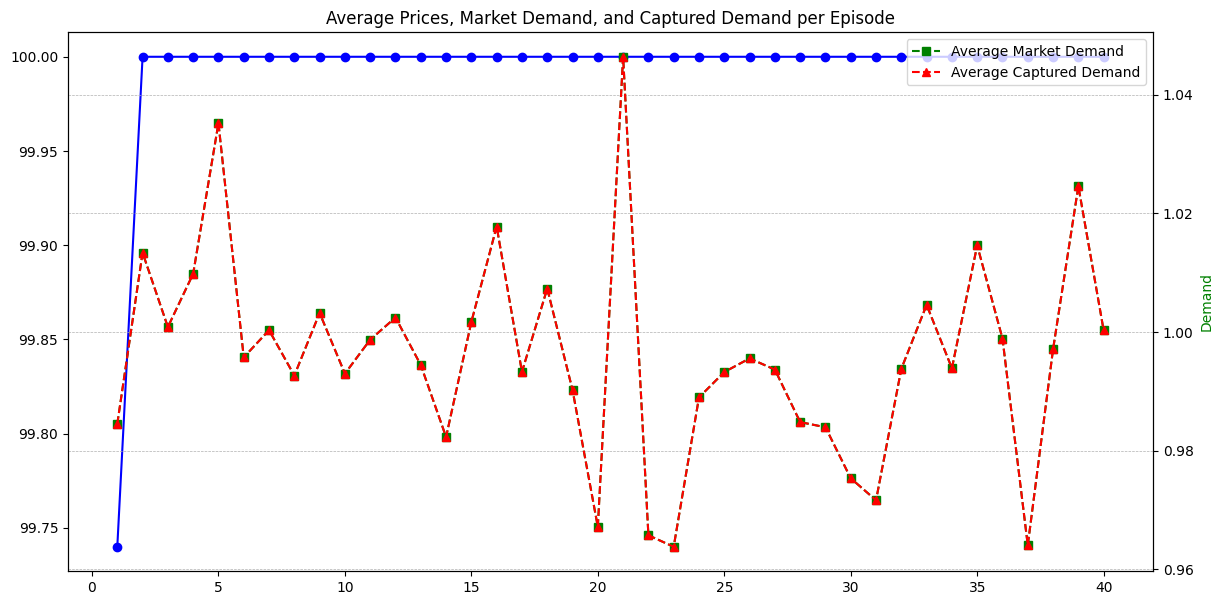

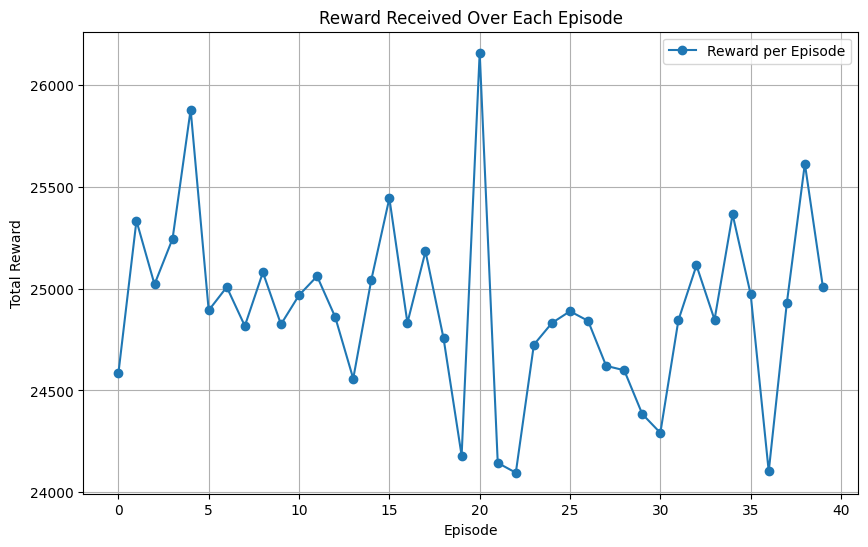

In [35]:
ucb_agent = UCB1(len(action_prices))

env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=True, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)


prices_per_episode = []  # Store prices for each episode
market_demands_per_episode = []  # Store market demands for each episode
captured_demands_per_episode = []  # Store captured demands for each episode
episode_rewards = []
for episode in range(num_episodes):
    total_reward = 0
    episode_prices = []  # Prices for the current episode
    episode_market_demands = []  # Market demands for the current episode
    episode_captured_demands = []  # Captured demands for the current episode
    
    for step in range(max_steps_per_episode):
        action = ucb_agent.select_action()
        price = action_prices[action]  # Direct price based on action
        episode_prices.append(price)
        
        next_state_info, reward, done, _ = env.step(price, external_demand_function())
        ucb_agent.update(action, reward)
        
        # Assuming you have a mechanism to calculate or retrieve captured demand
        market_demand = next_state_info[0]  # Example extraction of market demand
        captured_demand = env.current_demand  # Example extraction of captured demand
        
        episode_market_demands.append(market_demand)
        episode_captured_demands.append(captured_demand)
        
        total_reward += reward
        if done:
            break
    
    prices_per_episode.append(episode_prices)
    market_demands_per_episode.append(episode_market_demands)
    captured_demands_per_episode.append(episode_captured_demands)
    episode_rewards.append(total_reward)

# Calculate mean prices, market demands, and captured demands for each episode
mean_prices = [np.mean(prices) for prices in prices_per_episode]
mean_market_demands = [np.mean(demands) for demands in market_demands_per_episode]
mean_captured_demands = [np.mean(demands) for demands in captured_demands_per_episode]
episodes = range(1, num_episodes + 1)

# Visualization
plt.figure(figsize=(14, 7))

# Plotting average prices
plt.plot(episodes, mean_prices, label='Average Price', marker='o', linestyle='-', color='blue')

# Adding a secondary y-axis for demands
ax2 = plt.twinx()
ax2.plot(episodes, mean_market_demands, label='Average Market Demand', marker='s', linestyle='--', color='green')
ax2.plot(episodes, mean_captured_demands, label='Average Captured Demand', marker='^', linestyle='--', color='red')

plt.title('Average Prices, Market Demand, and Captured Demand per Episode')
plt.xlabel('Episode')
plt.ylabel('Price', color='blue')
ax2.set_ylabel('Demand', color='green')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)
